## T Cell Normalization <a class="tocSkip">

Loads T cell anndata, sets marker genes, annotates anndata with additional clinical information, scales/log normalizes counts and sets as default layer, sets HVGs, and plots unintegrated data. Exports unitegrated T cell h5ad and pickles marker gene dictionary.

Author: Kevin Hoffer-Hawlik

## Setup

In [1]:
import warnings
# warnings.simplefilter(action='ignore',)
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=ResourceWarning)

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import scipy.stats
import scib
import pickle

Global seed set to 0
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
warnings.simplefilter(action='ignore',)
warnings.simplefilter(action='ignore',)

## Load Data

In [ ]:
# load tcell data, markers, and patient metadata
tcells = sc.read_h5ad("unprocessed/data_melanoma_tcells_v2.h5ad")

treatment_time = pd.read_csv("clinical_data_time_treatment.csv")
treatment_time.set_index(keys = 'sample', inplace=True)

clinical_outcomes = pd.read_csv("ribas_survival.csv")
clinical_outcomes = clinical_outcomes.loc[pd.notna(clinical_outcomes.OS),['patient', 'survival_status', 'OS']]
clinical_outcomes.set_index(keys = 'patient', inplace=True)

/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_pca' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_umap' was written without encoding metadata.
  return {k: rea

/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/j_gene_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/mait_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/mait_evidence_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/mait_inkt_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/kh3205/anaconda3/e

In [6]:
# check for nans
check_nans = False
if check_nans:
    npt = np.asarray(tcells.to_df())

    for i in range(npt.shape[1]):
        if i%1000==0:
            print(i)
        for j in range(npt.shape[0]):
            if np.isnan(npt[j][i]):
                print("nan found")
                break
    print("finished checking for NaNs")

## Set Marker Genes

In [ ]:
# set marker genes for DEG

marker_genes = {
    'lineage_markers': ['CD3E', 'CD4', 'CD8A', 'CD8B'], 
    'naive_markers': ['SELL', 'IL7R', 'CCR7', 'CD27', 'CD28', 'HNRNPLL', 'PTPRC'],
    'memory_markers': ['CCL5', 'FAS', 'CD69', 'ITGAE', 'CXCR4'],
    'exhaustion_markers': ['PDCD1', 'KLRG1', 'TIGIT', 'HAVCR2', 'LAG3', 'CTLA4'],
    'activation_markers': ['ENTPD1', 'IL2RA', 'ICOS', 'TNFRSF4', 'TNFRSF8', 'CD40LG'],
    'effector_cytokines': ['GZMA', 'GZMB', 'GZMH', 'GZMK', 'GZMM', 'PRF1', 'GNLY', 'IFNG', 'TNF'],
    'transcription_factors': ['LEF1', 'TCF7', 'EOMES', 'TBX21', 'TOX', 'ID2', 'ID3', 'ZNF683', 'MKI67'],
    'self-renewal/memory markers': ['SELL', 'IL7R', 'FAS'], 
    'NK/gd T cell genes': ['TRGV9', 'KLRB1', 'KLRC1', "NCAM1"], #  added NCAM1 per Johannes
    'Th17': ['RORC', 'RORA', 'RUNX1', 'CEBPB', 'CLEC7A', 'SOCS1', 'SOCS3', 'STAT3', 'STAT4', 'STAT5A', 
             'STAT6', 'TBX21', 'TRAF6', 'IL17A', 'IL17C', 'IL17D', 'IL17F', 'IL18', 'IL2', 
             'IL1B', 'IL21', 'IL22', 'IL23A', 'IL25', 'IL27', 'IL3', 'IL17RA', 'IL17RB', 'IL17RC', 
             'IL17RE', 'CCR2', 'CCR6', 'IL1R1', 'IL23R', 'CD4'], 
    'Treg': ['NT5E', 'CD3D', 'CD3G', 'CD3E', 'CD4', 'CD5', 'ENTPD1', 'CTLA4', 'IZUMO1R', 'TNFRSF18',
             'IL2RA', 'ITGAE', 'LAG3', 'TGFB1', 'LRRC32', 'TNFRSF4', 'SELL', 'FOXP3', 'STAT5A',
             'STAT5B', 'LGALS1', 'IL10', 'IL12A', 'EBI3', 'TGFB1'],
    'Tfh': ['CD3D', 'CD3G', 'CD3E', 'CD28', 'CD28', 'CD40LG', 'CD84', 'LY9', 'CXCR4', 'CXCR5', 'ICOS',
            'IL6R', 'IL21R', 'SLAMF6', 'TNFRSF4', 'PDCD1', 'SLAMF1', 'BCL6', 'BATF', 'MAF', 
            'STAT3', 'IFNG', 'IL2', 'IL10', 'TNF', 'CD4'],
    'Th22': ['CCL15', 'CCR4', 'CCR6', 'CCR10', 'CD3G', 'CD3D', 'CD3E', 'CD4', 'CD247', 'IL6', 'IL6R',
             'IL10', 'IL13', 'IL21', 'IL21R', 'IL22', 'STAT3', 'TGFB1', 'TGFB2', 'TGFB3', 'TGFBR2', 
             'CD4'], 
    'Th9': ['CD3G', 'CD3E', 'CD4', 'CD247', 'IL2RG', 'IFNB1', 'IL1B', 'IL2RG', 'IL4', 'IL6', 
            'IL9', 'IL10', 'IL25', 'IL17RA', 'IL17RB', 'IL21', 'IRF4', 'TGFB3', 'SPI1', 
            'STAT6', 'TGFB2', 'TGFB1', 'TGFBR2', 'CD3D'],  
}

t_cell_processes = {
    'Pro_inflammatory': ['IL1A', 'IL1B', 'TNF', 'IFNG', 'TBX21', 'CCL3', 'CCL4', 'PRF1', 'GZMA', 
                         'GZMB', 'GZMK', 'GZMH', 'CD8A', 'FASLG', 'CCL2', 'CCL20', 'IL2', 'IL6', 
                         'IL12A', 'IL17A', 'IL23A', 'PTGS2', 'TLR4', 'TNF', ],
    'Cytolytics_effector_pathway': ['EOMES', 'TBX21', 'GZMB', 'PRF1', 'FASLG', 'GZMH', 'GZMA'],
    'CD8_T_cell_activation': ['CD69', 'CCR7', 'CD27', 'BTLA', 'CD40LG', 'IL2RA', 'CD3E', 'CD47',
                              'EOMES', 'GNLY', 'GZMA', 'GZMB', 'PRF1', 'IFNG', 'CD8A', 'CD8B', 
                              'FASLG', 'LAMP1', 'LAG3', 'CTLA4', 'HLA-DRA', 'TNFRSF4', 'ICOS',
                              'TNFRSF9', 'TNFRSF18', ], 
    'Type_I_interferon_response': ['IRF1', 'IFIH1', 'IFITM3', 'DDX58', 'IFI44L', 'IFI6', 'IFITM2', 
                                   'NAMPT', 'OASL','RTP4', 'TREX1', 'ADAR', 'TENT5C', 'LY6E', 'MCOLN2', 
                                   'APOBEC3G', 'IL15', 'ISG15', 'MX1', 'TLR3',], 
    'Type_II_interferon_response': ['IFNG', 'CXCL9', 'CXCL10', 'STAT1', 'HLA-A', 'HLA-B', 'HLA-C',
                                    'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1',
                                    'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1',
                                    'HLA-DRB5','CD274', 'CDKN1A', 'MYC', 
                                    'SMAD7', 'IRF1',], 
    'Exhaustion/Terminal_differentiation': ['TIGIT', 'PDCD1', 'CD274', 'CTLA4', 'LAG3', 'HAVCR2', 
                                            'CD244', 'CD160',],
    'CD8_deletional_tolerance': ['TNFSF11', 'RGS16', 'NRN1', 'IKZF2', 'TBC1D4', 'NR4A2', 
                                 'GPM6B', 'ENDOD1', 'FCRL1', 'LRIG1', 'MARCKS', 'NR4A3', 
                                 'LTA', 'SYNJ2', 'NR4A1', 'HSPA4L', 'PTPRS', 'EGR2', 'CYTH3', 
                                 'YPEL2', 'SKIL', 'NAB2', 'SOAT1', 'GALM', 'TOX', 'REEP3', 
                                 'MDH1', 'EPHX1', 'SSH1', 'CREM', 'PACSIN1', 'LPCAT1', 'PRMT2', 
                                 'CD200R1', 'NRIP1', 'DGKZ', 'RASA1', 'H3F3B', 'FAM174B',],
    'CD8_TIL_dysfunction': ['NPEPPS', 'NOTCH2', 'CABLES1', 'CERK', 'MTMR3', 'RELB', 'KLF3', 
                            'CAMK2D', 'CCNG2', 'SLC25A33', 'PIM3', 'RNF149', 'SWAP70', 
                            'PINK1', 'RAB2A', 'FAM168B', 'MAP2K7', 'ASAP1', 
                            'GRASP', 'POU2AF1', 'GATA3', 'B3GNT2', 'FAS', 'PIAS2', 'FOXO1', 
                            'SEC24B', 'TUBB2B', 'PARP3', 'PIGH', 'BRAP', 'ATP6V0D1', 'IFT80', 
                            'FRRS1', 'GPR132', 'SPI1', 'SH2B3', 'ANOS1', 'CD74', 'TBC1D22B', 
                            'CD19', 'PHC2', 'TRAT1', 'SLAMF6', 'YPEL3', 'RARA', 
                            'MAN1A1', 'CRTC3', 'MKRN1', 'BCL6', 'CLN6', 'MYB', 'NDUFV1', 'SLC28A2', 
                            'FBXL20', 'SCIN', 'LGMN', 'WTAP', 'BCL3', 'SLC2A6', 'IL2RG', 'SNTB1', 
                            'KDM5B', 'UTP15', 'LATS2', 'RASSF2', 'IFI30', 'KDM4B', 'IER5', 'CD5', 
                            'MNDA', 'PCGF5', 'GPR35', 'SPRY1', 'TNIP1', 'CSNK1D', 'NSMCE1', 'NR4A1', 
                            'OSBPL11', 'PNRC1', 'ITGAE', 'SNX18', 'PIP4P1', 'IKZF2', 'ISCU', 
                            'INSYN2B', 'TMEM243', 'ZFP62', 'RASGEF1B', 'DTWD1', 'GNA13', 'JAK2', 
                            'EIF3F', 'CCR7', 'SGPP1', 'SLAMF7', 'QRICH1', 'EML4', 'CACNB3',],
    'G2/M': ['AURKA', 'BIRC5', 'BUB1', 'BUB1B', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNF', 'CDC20', 
             'CDC25B', 'CDC25C', 'CDK1', 'CDKN2D', 'CENPA', 'CENPF', 'CKS2', 'KIF20A', 
             'PLK1', 'RACGAP1', 'TOP2A',],
    'G1/S': ['BRCA1', 'BRCA2', 'CCNE1', 'CCNE2', 'CCNG2', 'CDC25A', 'CDC45', 'CDC6', 'CDKN1A', 
             'CDKN2C', 'CDKN3', 'DHFR', 'E2F1', 'E2F5', 'H1F0', 'H1FNT', 'H1FOO', 'H1FX', 
             'H2AFB1', 'H2AFB2', 'H2AFB3', 'H2AFJ', 'H2AFV', 'H2AFX', 'H2AFY', 
             'H2AFY2', 'H2AFZ', 
             'H2BFM', 'H2BFS', 'H2BFWT', 'H3F3A', 
             'H3F3B', 'H3F3C', 'HIST1H1A', 'HIST1H1B', 'HIST1H1C', 'HIST1H1D', 'HIST1H1E',
             'HIST1H1T', 'HIST1H2AA', 'HIST1H2AB', 'HIST1H2AC', 
             'HIST1H2AD', 'HIST1H2AE', 'HIST1H2AG', 'HIST1H2AH', 'HIST1H2AI', 'HIST1H2AJ', 
             'HIST1H2AK', 'HIST1H2AL', 'HIST1H2AM', 
             'HIST1H2BA', 'HIST1H2BB', 'HIST1H2BC', 'HIST1H2BD', 
             'HIST1H2BE', 'HIST1H2BF', 'HIST1H2BG', 'HIST1H2BH', 'HIST1H2BI', 'HIST1H2BJ', 
             'HIST1H2BK', 'HIST1H2BL', 'HIST1H2BM', 'HIST1H2BN', 'HIST1H2BO', 
             'HIST1H3A', 'HIST1H3B', 'HIST1H3C', 'HIST1H3D', 'HIST1H3E', 
             'HIST1H3F', 'HIST1H3G', 'HIST1H3H', 'HIST1H3I', 'HIST1H3J', 
             'HIST1H4A', 'HIST1H4B', 'HIST1H4C', 'HIST1H4D', 'HIST1H4E', 'HIST1H4F', 
             'HIST1H4H', 'HIST1H4I', 'HIST1H4J', 'HIST1H4K', 'HIST1H4L', 
             'HIST2H2AA3', 'HIST2H2AA4', 'HIST2H2AB', 'HIST2H2AC', 
             'HIST2H2BE', 'HIST2H2BF', 'HIST2H3A', 'HIST2H3C', 
             'HIST2H3D', 'HIST2H3PS2', 'HIST2H4A', 'HIST2H4B', 'HIST3H2A', 
             'HIST3H2BB', 'HIST3H3', 'HIST4H4', 'MCM2', 'MCM6', 'MSH2', 'NASP', 'NPAT', 
             'PCNA', 'RRM1', 'RRM2', 'SLBP', 'TYMS',],
    'Glycogen_metabolism': ['GBE1', 'GYS1', 'GYS2', 'UGP2', 'AGL', 'PGM1', 'PGM2', 'PGM3', 
                            'PYGL', 'PYGM', 'GSK3A', 'GSK3B', 'PHKA1', 'PHKB', 'PHKG1', 'PHKG2',],
    'Hypoxia/HIF_regulated': ['ALDOA', 'BCL2', 'BCL2L1', 'FOS', 'JUN', 'SRC',
                              'PAG1', 'CCR6', 'CEBPB', 'FAS', 'FASLG', 'FKBP4', 'GAPDH', 
                              'CSF2', 'IFNG', 'IFNB1', 'IL13', 'IL1R1', 'IL2RA', 
                              'IL5', 'IL6R', 'CXCL8', 'IL10RA', 'IL15RA', 'ITGA6', 'ITK', 'JUND', 
                              'MAP3K5', 'MAP2K1', 'MAP2K2', 'MIF', 'NFATC1', 'NFKB2', 
                              'NFKBIE', 'TP53', 'TGM6', 'TNF', 'TNFRSF1B', 'TRADD', 'TNFSF10', 
                              'TRAP1', 'VEGFA',],
    'CD4_T _cell_anergy': ['ACTN4', 'ADORA2A', 'ADORA2B', 'AGT', 'ANGPTL2', 'ANKRD28', 'ANP32A', 
                           'ARFIP1', 'BNIP3', 'CASP4', 'CCL1', 'CCL3', 'CD40LG', 'ADGRE5',
                           'CDC14A', 'CLEC4E', 'CSF1', 'CTSE', 'DDR1', 'DLG2', 'DTNA', 'DUSP6',
                           'EGR2', 'ETV6', 'F2R', 'FBXO34', 'FOXP1', 'FURIN', 'FYN', 'GABRA4',
                           'GADD45B', 'GCH1', 'GGA2', 'HEBP2', 'HIF1AN', 'HLF', 'HSD17B6', 'HSPA4L',
                           'IER3', 'ING4', 'IRF4', 'ISYNA1', 'JAK3', 'JARID2', 'JUP', 'KCNJ11',
                           'KCNK5', 'KCNQ5', 'KIF15', 'KIFC3', 'LAG3', 'LDHB', 'LPAR4', 'LRRC3',
                           'MMD', 'MPZL2', 'MYH14', 'MYL7', 'MYO1C', 'MYO1E', 'NDRG1',
                           'NFATC1', 'NOTCH1', 'NR4A2', 'NR4A3', 'OAZ3', 'PFKP', 'PLA2G10', 'RCBTB1',
                           'RNF19A', 'S100A5', 'SFRP4', 'SLC29A3', 'SOCS4', 'SRGN', 'STX11', 'TEKT2',
                           'TINAG', 'TNFRSF19', 'TNFRSF4', 'TNFSF11', 'TNFSF9', 'TP53RK', 'ZFP36L1',
                           'ZNF629', 'ZNF629',],
    'CD8_peripheral_tolerance': ['LAG3', 'NDRG1', 'E2F1', 'E2F2', 'RGS16', 'PTPRS', 'SPDL1',
                                 'RCC1', 'CENPA', 'CENPM', 'CENPH', 'INCENP', 'BIRC5', 'BUB1B', 
                                 'MAD2L1', 'MCM10', 'MCM6', 'MCM5', 'MCM2', 'CDCA2', 'CDCA3', 'CDCA5',
                                 'CDCA7', 'CDC6', 'CDC45', 'CDC20', 'CDC7', 'CDK1', 'KIF15', 'KIF2C',
                                 'KIF22', 'KIF11', 'KIF4A', 'HIST1H3D', 'HIST1H3I', 'HIST2H3D', 
                                 'HIST1H3A', 'HIST1H3E', 'HIST1H2BN', 'HIST1H2BM', 'HIST1H2BH',
                                 'HIST1H2BK', 'HIST1H2BG', 'HIST1H2BL', 'HIST1H2BM', 'HIST1H2AD', 
                                 'HIST1H2AB', 'HIST1H2AJ', 'HIST1H2AG', 'HIST1H2AH', 'HIST1H2AA',
                                 'HIST1H2AM', 'HIST1H2AK', 'HIST1H2AC', 'HIST2H2AB', 'HIST2H2AC',],
    'Anti-inflammatory': ['TIGIT', 'IDO1', 'LGALS3', 'PDCD1', 'FOXP3', 'ENTPD1', 'CD274', 'CSF2', 
                          'CTLA4', 'CXCL12', 'CXCL5', 'CXCL8', 'MIF', 'PTGS2', 'VEGFA',], 
    'TCA_cycle': ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2', 
                  'IDH3A', 'IDH3B', 'IDH3G', 'MDH1', 'MDH1B', 'MDH2', 'OGDH', 'PC', 'PCK1', 'PCK2', 
                  'PDHA1', 'PDHB', 'SDHA', 'SDHB', 'SDHD', 'SUCLA2', 'SUCLG1', 'SUCLG2'],
    'Pentose_phosphate_pathway': ['G6PD', 'PGLS', 'PRPS1', 'PRPS2', 'RBKS', 
                                  'RPE', 'RPIA', 'TALDO1', 'TKT'],
    'Senescence': ['B3GAT1', 'KLRG1', 'FAS', 'DUSP4', 'DUSP5', 'DUSP6', 'GNA15', 'CDKN1A', 
                   'EGR1', 'GADD45A', 'NR4A1', 'NR4A3',],
    'Adenosine_pathway': ['ENTPD1', 'NT5E', 'ADORA2A', 'ADORA2B', 'ADORA1', 'ADORA3', 'HIF1A',],
    'Glucose_deprivation': ['NRN1', 'NIBAN1', 'SPRY1', 'GADD45B', 'HSPA1A', 'HSPA1B',
                            'GPNMB', 'HAVCR2', 'SOAT2', 'ADAMTS6'],
    'T_cell_co-inhibitory_receptors': ['LAG3', 'PDCD1', 'HAVCR2', 'CD160', 'CD244', 'TIGIT', 
                                       'BTLA', 'CTLA4', 'TNFRSF14', 'PVRIG',],
    'Effector_cell_cytotoxicity': ['GZMB', 'GZMA', 'GZMK', 'GZMH', 'GZMM', 'PRF1', 'CST7', 'NKG7', 
                                   'GNLY', 'CCL4', 'LAMP1', 'LAMP2', 'CRTAM', 'HCST','NCR3',],
    'Terminal_exhaustion': ['CD3G', 'FASLG', 'ID2', 'LAG3', 'RGS1', 'CCL3', 'CCL3L1', 'KIAA1671', 
                            'SH2D2A', 'DUSP2', 'PDCD1', 'CD7', 'NR4A2', 'CD160', 'PTPN22', 'ABI3', 
                            'PTGER4', 'GZMK', 'GZMA', 'MBNL1', 'VMP1', 'PLAC8', 'RGS3', 'EFHD2', 
                            'GLRX', 'CXCR6', 'ARL6IP1', 'CCL4', 'ISG15', 'LAX1', 'CD8A', 'SERPINA3', 
                            'GZMB', 'TOX',],
    'Precursor_exhaustion': ['TCF7', 'MS4A4A', 'TNFSF8', 'CXCL10', 'EEF1B2', 'ID3', 'IL7R', 'JUN', 'LTB',
                             'XCL1', 'SOCS3', 'TRAF1', 'EMB', 'CRTAM', 'EEF1G', 'CD9', 'ITGB1', 'GPR183', 
                             'ZFP36L1', 'SLAMF6', 'LY6E',],
}

signed_t_cell_processes = {
    'T_naive': ['HNRNPLL-', 'CCR7+', 'SELL+', 'CD28+', 'CD27+', 'IL7R+', 'CXCR3-', 'FAS-', 'ITGAL-', 
                'IL2RB-', 'CD58-', 'B3GAT1-',],
    'T_stem_central_memory': ['HNRNPLL-', 'CCR7+', 'SELL+', 'CD28+', 'CD27+', 'IL7R+', 'CXCR3+', 
                              'FAS+', 'ITGAL+', 'IL2RB+', 'CD58+', 'B3GAT1-',],
    'T_central_memory': ['HNRNPLL+', 'CCR7+', 'SELL+', 'CD28+', 'CD27+', 'IL7R+', 'CXCR3+', 'FAS+', 
                         'ITGAL+', 'IL2RB+', 'CD58+', 'B3GAT1-'],
    'T_effector_memory': ['HNRNPLL+', 'CCR7-', 'SELL-', 'CXCR3-', 'FAS+', 'ITGAL+', 'IL2RB+', 'CD58+'],
    'T_terminal_effector': ['HNRNPLL-', 'CCR7-', 'SELL-', 'CD28-', 'CD27-', 'IL7R-', 'CXCR3-', 'FAS+', 
                            'ITGAL+', 'IL2RB+', 'CD58+', 'B3GAT1+',],
}

# loop through flattened gene list to extract unsigned gene names
unsigned_t_cell_processes = []
for token in [v2 for v in signed_t_cell_processes.values() for v2 in v]:
    if token[-1] == '+':
        unsigned = token.split('+')[0]
    else:
        unsigned = token.split('-')[0]
    unsigned_t_cell_processes.append(unsigned)

# combine into simple marker genes dictionary
marker_genes = marker_genes | t_cell_processes

# flatten the gene list
marker_genes_list = [v2 for v in marker_genes.values() for v2 in v]
marker_genes_list = marker_genes_list + unsigned_t_cell_processes

# check each of the marker genes are in the dataset
missing = []
for gene in marker_genes_list:
    if gene not in set(tcells.var_names):
        missing.append(gene)
if len(missing)>0:
    display(missing)
    
# finally, add signed genes into marker_genes dictionary
marker_genes = marker_genes | signed_t_cell_processes

## Pre-processing and QC

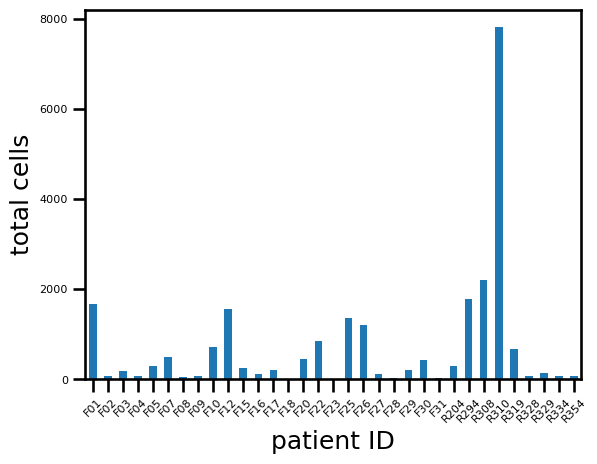

In [9]:
# summarize counts by each patient
counts_dict = {}
for patient in tcells.obs.patient.values.unique():
    counts_dict[patient] = [tcells[tcells.obs.patient.isin([patient])].shape[0]]
counts = pd.DataFrame(data = counts_dict)
counts = counts.T
counts.plot.bar(legend = False, rot = 45, fontsize = 8, ylabel = 'total cells', xlabel = 'patient ID');

In [10]:
# add source for HVG analysis, before scVI
tcells.obs["cohort"] = tcells.obs["sample"].str[0]

In [ ]:
# add survival data for each sample to anndata
treatment_time.loc[:,'days_since_ICI_start'] = treatment_time.clip(
    upper=pd.Series({'days_since_ICI_start':750}), axis=1) # cap at 3000 (3 outliers)
tcells.obs['days_to/from_ICI_start'] = tcells.obs['sample'].map(treatment_time['days_since_ICI_start'])
tcells.obs['treatment_duration'] = tcells.obs['sample'].map(treatment_time['treatment_duration'])

In [12]:
# add survival data for each sample to anndata
clinical_outcomes.loc[:,'OS'] = clinical_outcomes.clip(
    upper=pd.Series({'OS':1500}), axis=1) # cap at 1500 (3 outliers)
tcells.obs['survival_status'] = tcells.obs['patient'].map(clinical_outcomes['survival_status'])
tcells.obs['OS'] = tcells.obs['patient'].map(clinical_outcomes['OS'])

In [15]:
# check each of the marker genes are in the dataset
missing = []
for gene in marker_genes_list:
    if gene not in set(tcells.var_names):
        missing.append(gene)
        
if len(missing)>0:
    print('filtered genes:', missing)

In [16]:
# remove marker genes filtered out
for gene in missing:
    marker_genes_list.remove(gene)
    
    for dict_list in marker_genes.values():
        try:
            dict_list.remove(gene)
        except ValueError:
            pass

## Unintegrated Count Normalization and Feature Selection

In [ ]:
tcells.layers["counts"] = tcells.X.copy() # save raw counts

# store the current 'total_counts' under 'original_total_counts', which will not automatically be updated by scanpy in subsequent filtering steps
tcells.obs['original_total_counts'] = tcells.obs['total_counts']

# log10 original library size
tcells.obs['log10_original_total_counts'] = np.log10(tcells.obs['original_total_counts'])

# Normalize by median library size
sc.pp.normalize_total(tcells, exclude_highly_expressed=True) # default normalizes to median of original total counts

# log transform + 1 and updates adata.X
sc.pp.log1p(tcells)

# save normalized/logarithmized expression as a layer and set .raw for DEG/visualizations
tcells.layers["log_counts"] = tcells.X.copy()
tcells.raw = tcells

In [18]:
# perform feature selection to reduce # genes inputed into scVI model
sc.pp.highly_variable_genes( 
    tcells,
    n_top_genes=8000,
    # subset=True, # since we will subset manually
    layer="counts",
    flavor="seurat_v3",
    batch_key="cohort")

# append marker genes to HVG list
marker_genes_list = list(set(marker_genes_list) & set(tcells.var_names))
tcells.var['highly_variable'].loc[marker_genes_list] = True
tcells = tcells[:, tcells.var['highly_variable']]

# remove MT, Ribo, and Hb genes
tcells = tcells[:, ~tcells.var['mt']]
tcells = tcells[:, ~tcells.var['ribo']]
tcells = tcells[:, ~tcells.var['hb']]

print(tcells.shape)

(23658, 8170)


## Plot data (pre-scVI)

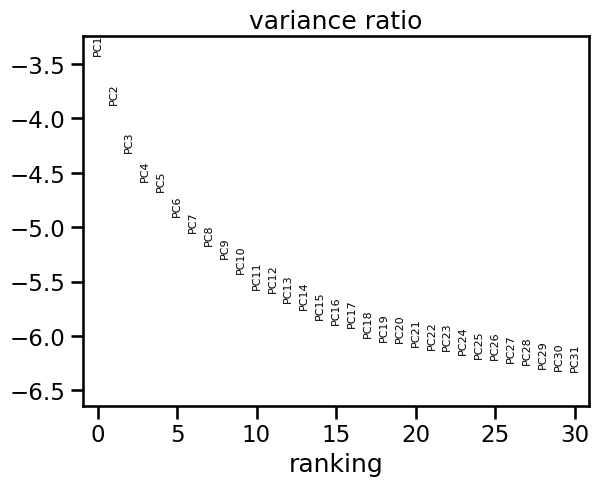

In [19]:
sc.tl.pca(tcells, svd_solver='arpack', n_comps = 100) # run PCA
sc.pl.pca_variance_ratio(tcells, log=True)

sc.pp.neighbors(tcells, n_pcs=30, n_neighbors=20) # compute neighborhood graph using PCA

sc.tl.umap(tcells) # embed neighborhood graph into UMAP

In [20]:
# sc.tl.leiden(tcells, resolution=0.5) # cluster the neighborhood graph
communities, graph, Q = sc.external.tl.phenograph(tcells.obsm['X_pca'], k = 30, resolution_parameter=1)
tcells.obs['PhenoGraph_unint_30'] = pd.Categorical(communities)
tcells.uns['PhenoGraph_unint_30_Q'] = Q

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 27.907320976257324 seconds
Jaccard graph constructed in 5.187970399856567 seconds
Wrote graph to binary file in 0.31899213790893555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.825033
After 3 runs, maximum modularity is Q = 0.826255
Louvain completed 23 runs in 8.316929578781128 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 45.09517025947571 seconds


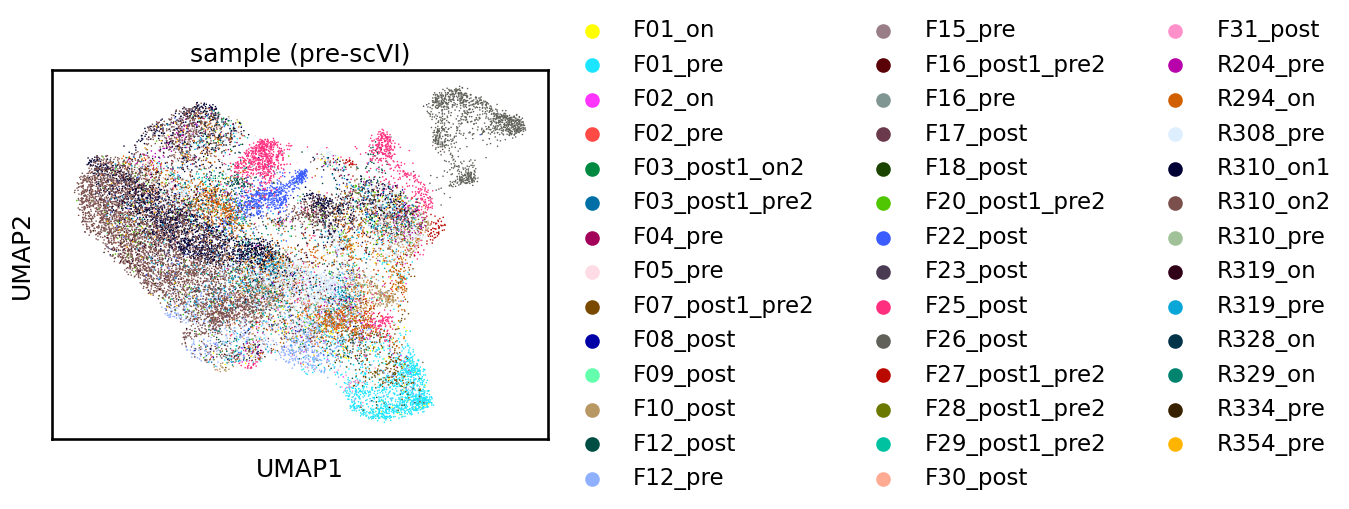

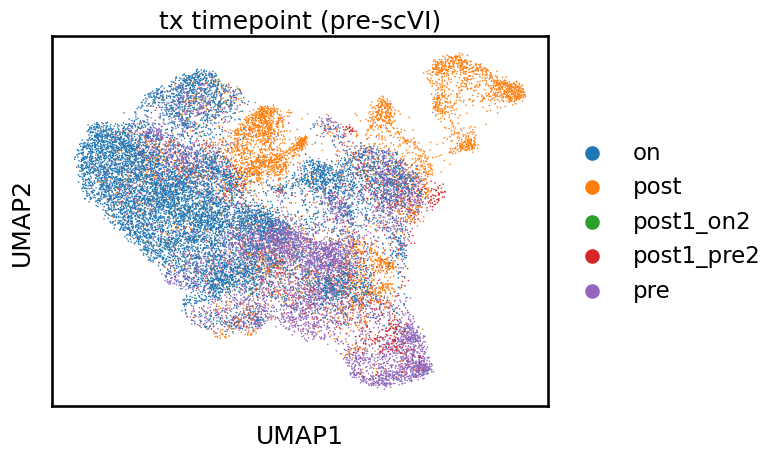

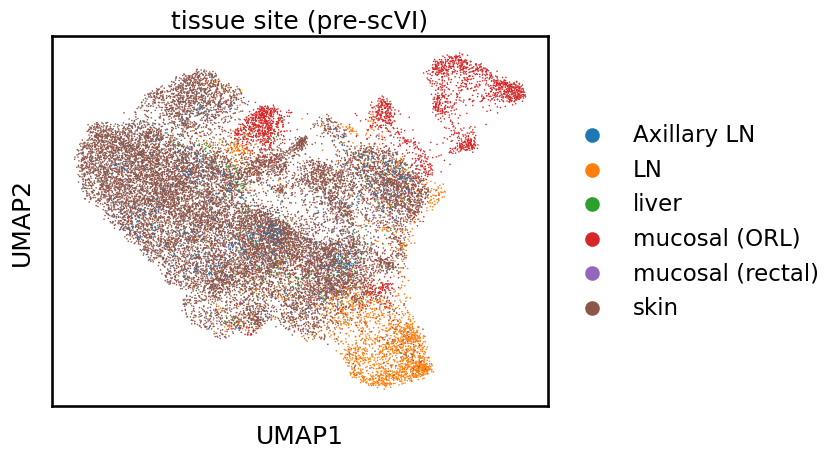

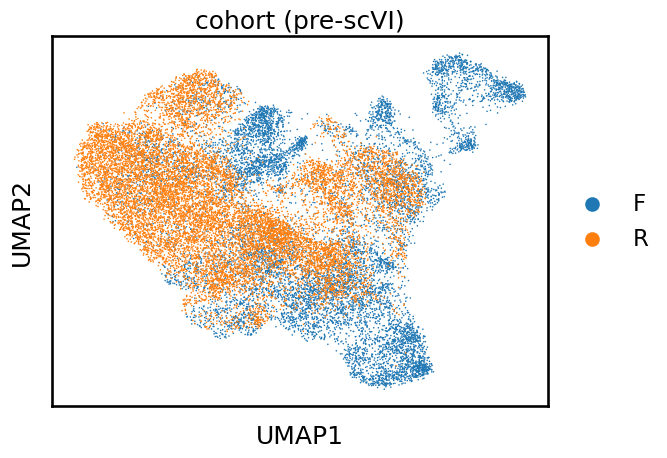

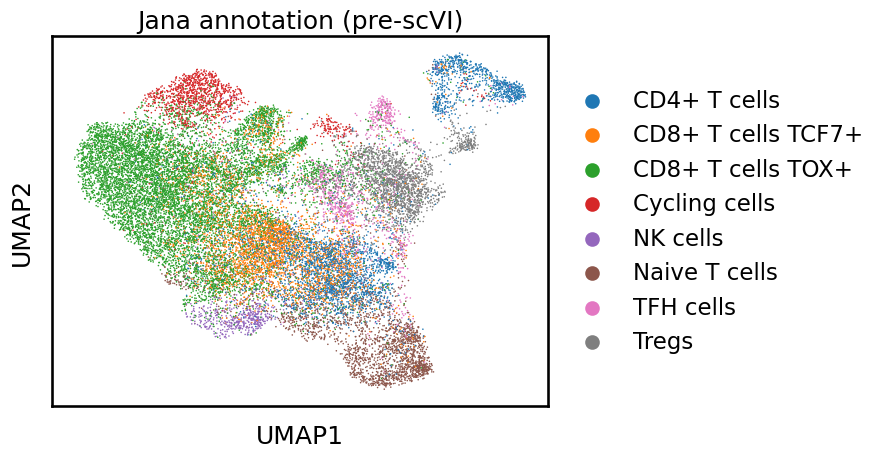

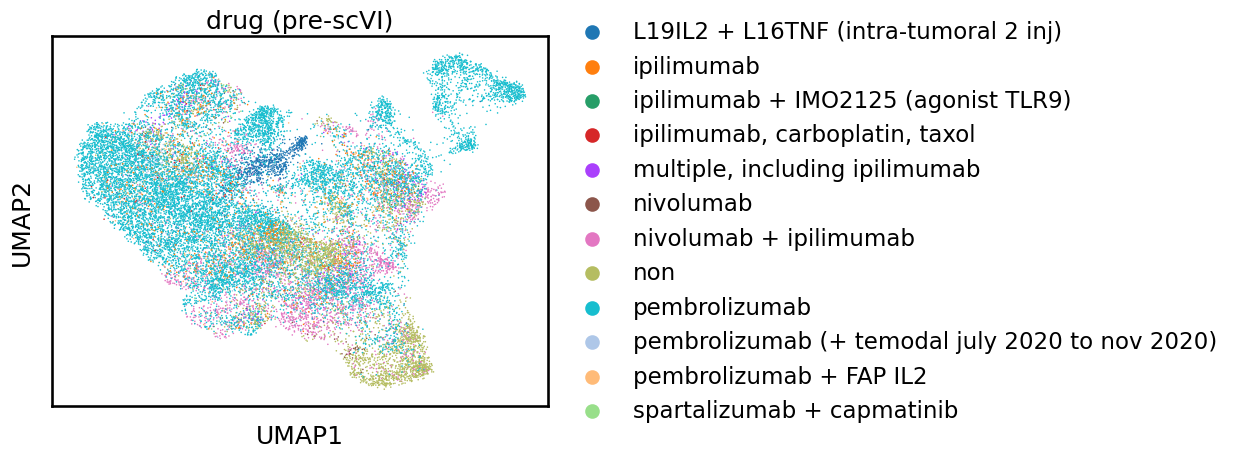

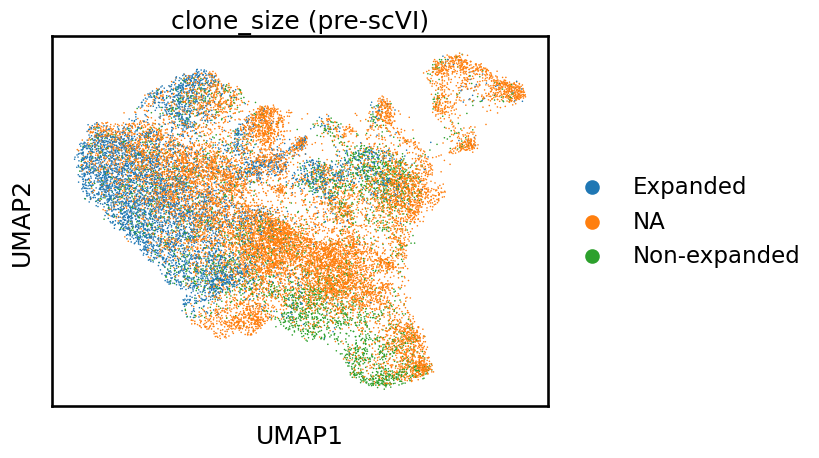

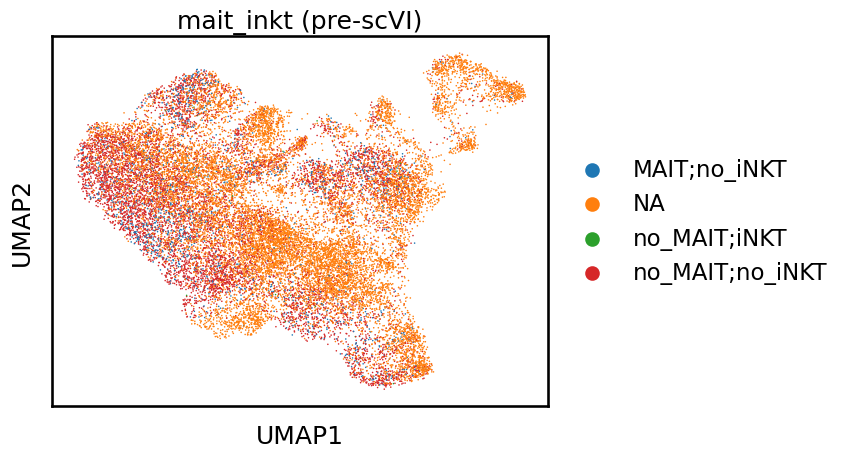

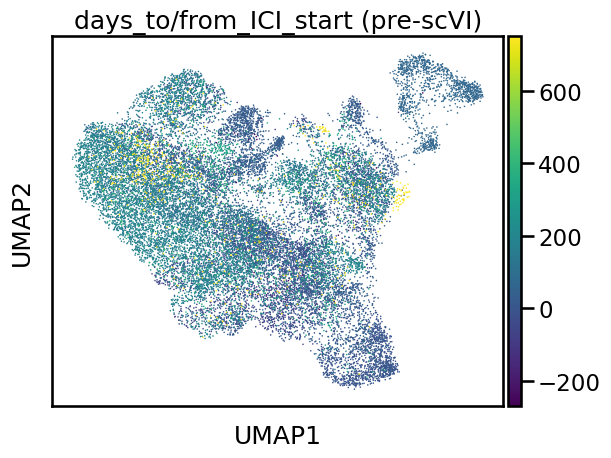

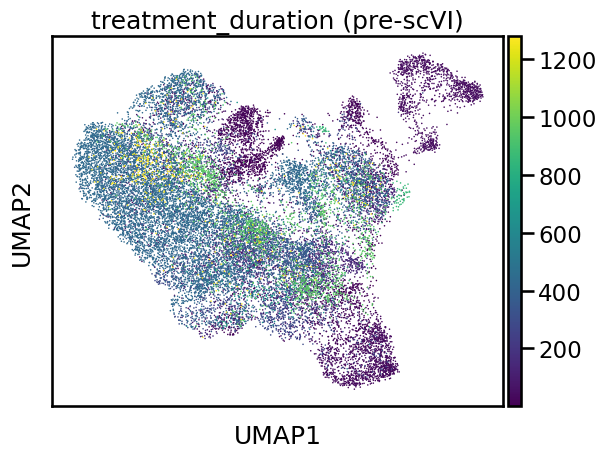

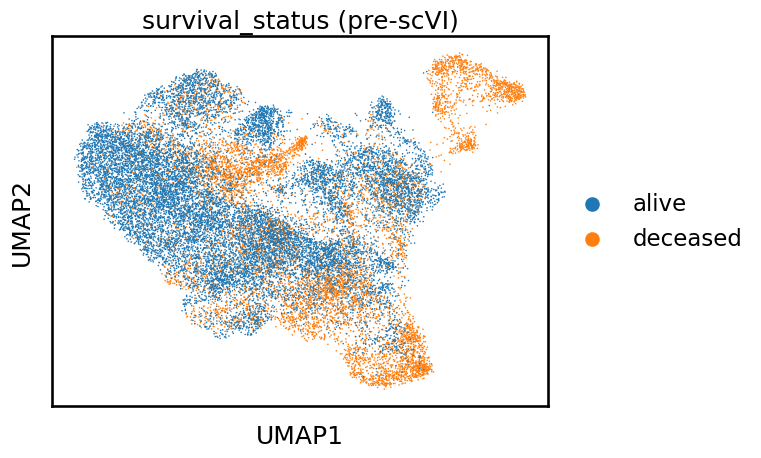

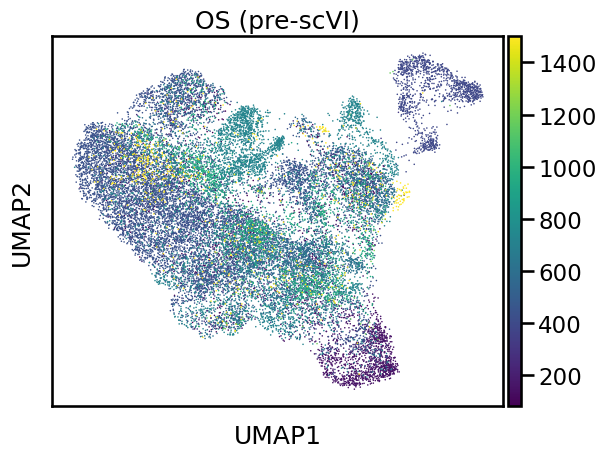

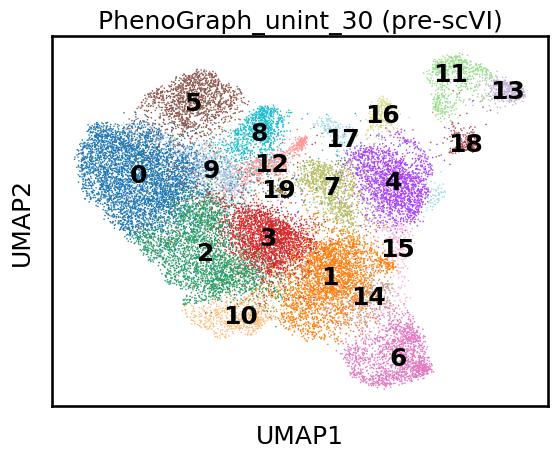

In [ ]:
sc.pl.umap(tcells, color=["sample"], title="sample (pre-scVI)")
sc.pl.umap(tcells, color=["timepoint"], title='tx timepoint (pre-scVI)')
sc.pl.umap(tcells, color=["tissue"], title='tissue site (pre-scVI)')
sc.pl.umap(tcells, color=["cohort"], title='cohort (pre-scVI)')
sc.pl.umap(tcells, color=["cell_type_fine"], title='Jana annotation (pre-scVI)')
sc.pl.umap(tcells, color=["Drug"], title='drug (pre-scVI)')
sc.pl.umap(tcells, color=["clone_size"], title='clone_size (pre-scVI)')
sc.pl.umap(tcells, color=["mait_inkt"], title='mait_inkt (pre-scVI)')
sc.pl.umap(tcells, color=["days_to/from_ICI_start"], title='days_to/from_ICI_start (pre-scVI)')
sc.pl.umap(tcells, color=["treatment_duration"], title='treatment_duration (pre-scVI)')
sc.pl.umap(tcells, color=["survival_status"], title='survival_status (pre-scVI)')
sc.pl.umap(tcells, color=["OS"], title='OS (pre-scVI)')
sc.pl.umap(tcells, color="PhenoGraph_unint_30", legend_loc='on data', title='PhenoGraph_unint_30 (pre-scVI)')

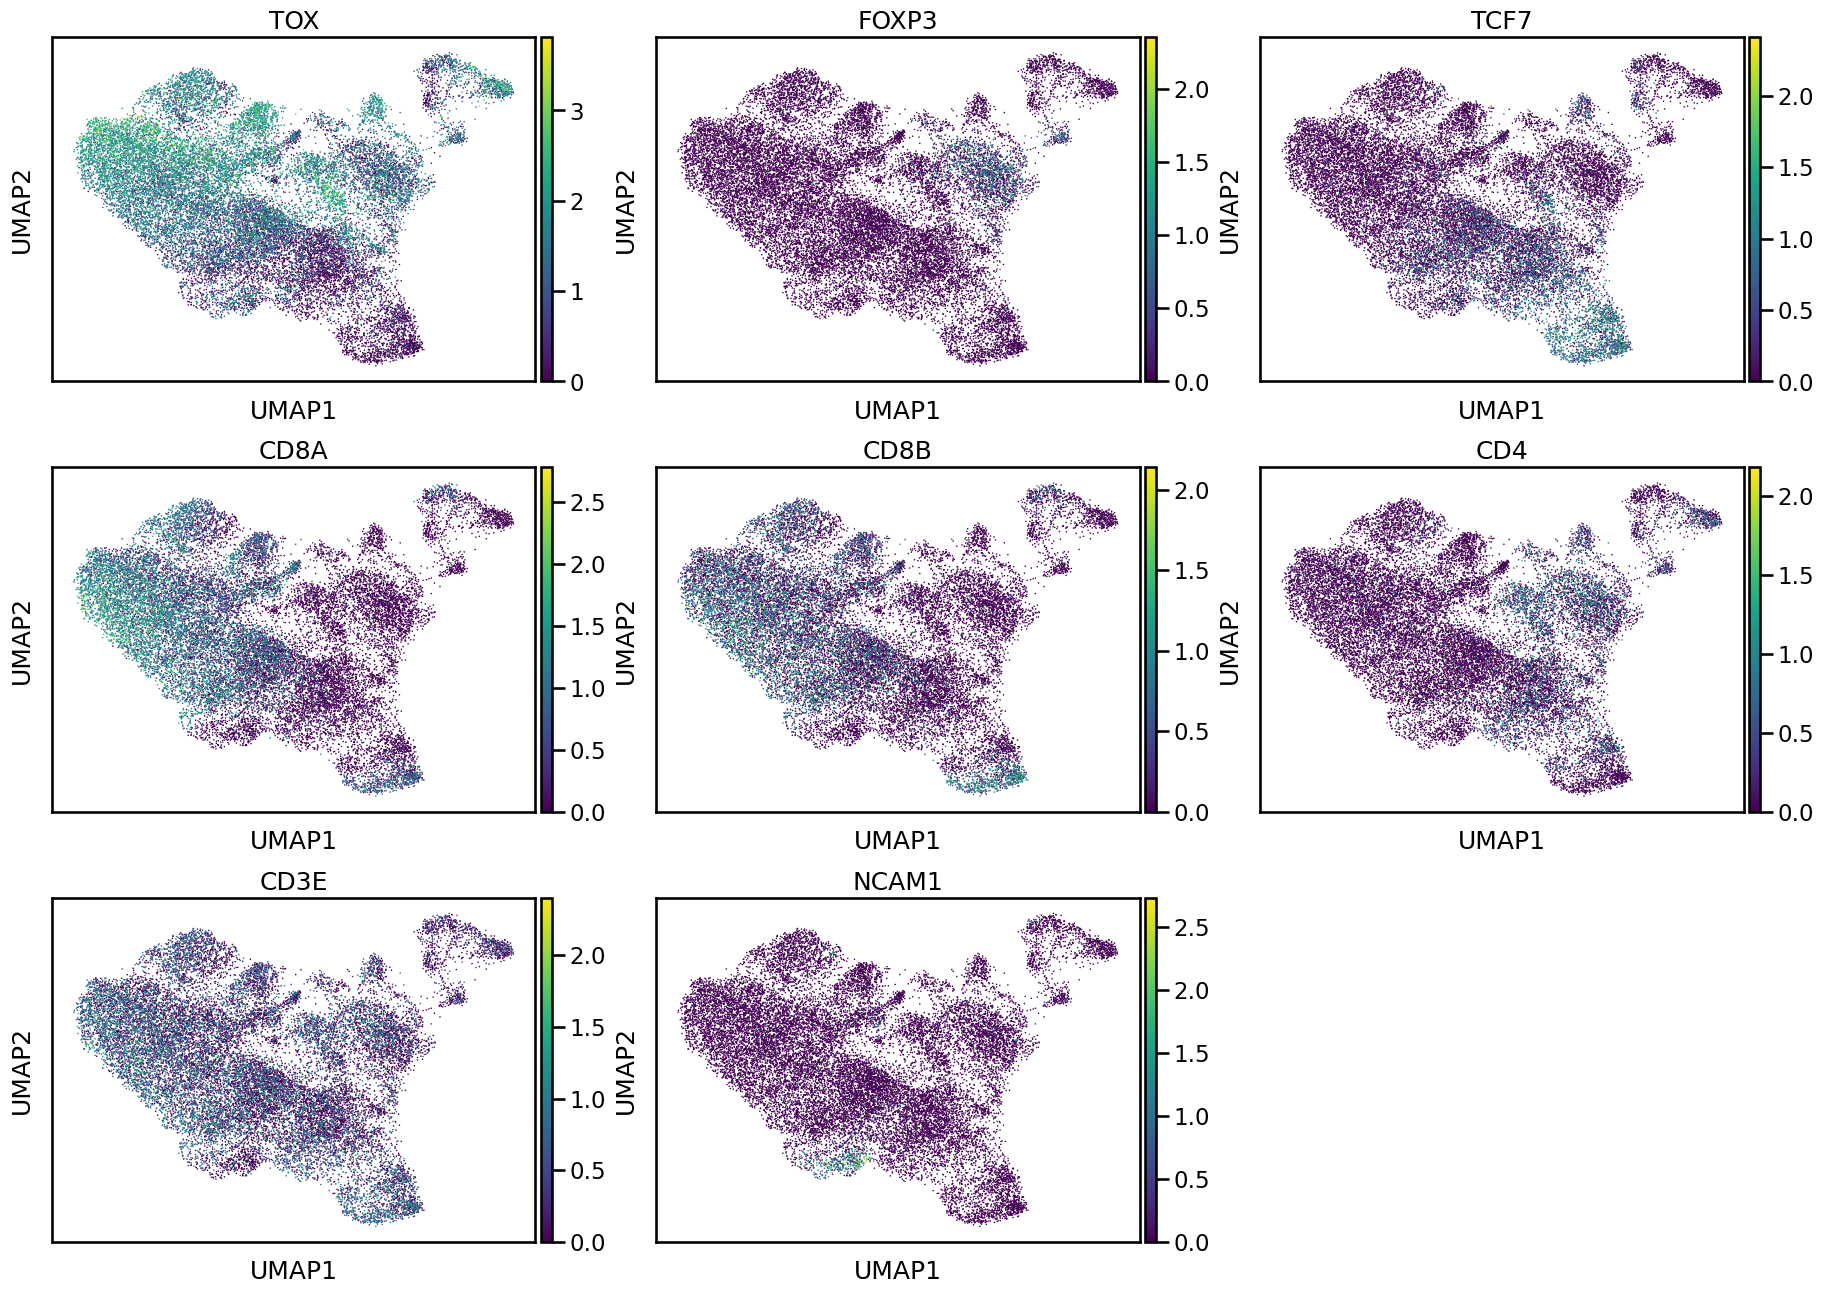

In [22]:
# for key in marker_genes.keys():
#     print(key)
#     sc.pl.umap(tcells,color=sorted(marker_genes[key]), ncols=3)
other_genes_of_interest = ["TOX", "FOXP3", "TCF7", "CD8A", "CD8B", "CD4", "CD3E", "NCAM1"]
sc.pl.umap(tcells, color=other_genes_of_interest, ncols=3)

## Export Working Files (Unintegrated Anndata, Marker Genes Dictionary)

In [23]:
tcells.write("tcells_unintegrated_030823.h5ad") # save anndata

# save marker genes list 
with open('marker_genes_dict_030823.pickle', 'wb') as handle:
    pickle.dump(marker_genes, handle, protocol=pickle.HIGHEST_PROTOCOL)